In [1]:
!pip install numpy==1.26.4 --force-reinstall

!pip install scikit-surprise

!pip install -q kaggle

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

# **Load Data**

In [3]:
!mkdir ~/.kaggle
!echo '{"username":"laetishaharyanto","key":"8bf76bb9718e1557e200a90de3ca6a92"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jahnavipaliwal/video-game-reviews-and-ratings

# Ekstrak file ZIP menggunakan unzip
!unzip -q video-game-reviews-and-ratings.zip -d video_game_reviews

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings
License(s): apache-2.0
video-game-reviews-and-ratings.zip: Skipping, found more recently modified local copy (use --force to force download)
replace video_game_reviews/video_game_reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


In [4]:
df = pd.read_csv("video_game_reviews/video_game_reviews.csv")
df.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


# **Data Understanding**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47774 entries, 0 to 47773
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Game Title               47774 non-null  object 
 1   User Rating              47774 non-null  float64
 2   Age Group Targeted       47774 non-null  object 
 3   Price                    47774 non-null  float64
 4   Platform                 47774 non-null  object 
 5   Requires Special Device  47774 non-null  object 
 6   Developer                47774 non-null  object 
 7   Publisher                47774 non-null  object 
 8   Release Year             47774 non-null  int64  
 9   Genre                    47774 non-null  object 
 10  Multiplayer              47774 non-null  object 
 11  Game Length (Hours)      47774 non-null  float64
 12  Graphics Quality         47774 non-null  object 
 13  Soundtrack Quality       47774 non-null  object 
 14  Story Quality         

**Insight**:  
Terdapat 18 Variabel untuk dataset game, namun untuk proyek sistem rekomendasi ini hanya menggunakan 3 variabel sebagai berikut:
- Game Title : Nama game
- Genre : Kategori game (misal: Action, Puzzle)
- User Rating : Penilaian dari pengguna

In [6]:
# Deteksi Missing Values
df.isnull().sum()

,0
Game Title,0
User Rating,0
Age Group Targeted,0
Price,0
Platform,0
Requires Special Device,0
Developer,0
Publisher,0
Release Year,0
Genre,0


**Insight**: Tidak terdapat Missing Values

In [7]:
# Deteksi Data Duplikat
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 0


**Insight**: Tidak ada data duplikat

# **Exploratory Data Analysis**

### **Variabel Genre**

In [8]:
print('Banyak Genre:', len(df['Genre'].unique()))
print('Genre:', df['Genre'].unique())

Banyak Genre: 10
Genre: ['Adventure' 'Shooter' 'Sports' 'RPG' 'Simulation' 'Strategy' 'Fighting'
 'Action' 'Party' 'Puzzle']


In [9]:
from wordcloud import WordCloud

def wordcloud(data, title):
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

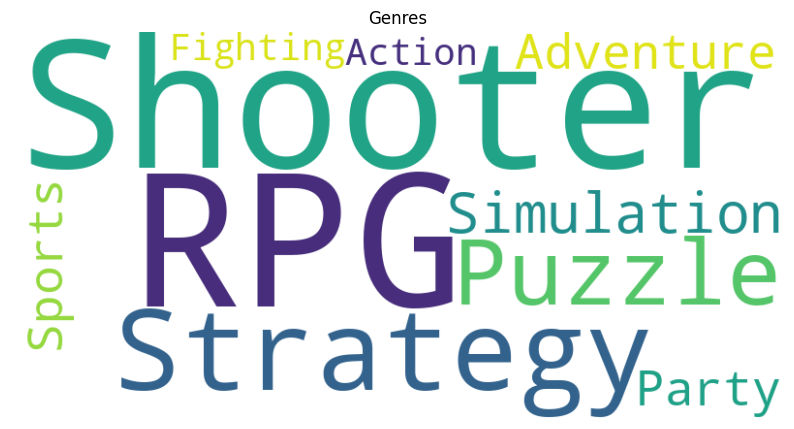

In [10]:
wordcloud(df['Genre'], 'Genres')

**Insight**:
- 3 Genre Game terbanyak yaitu **Strategy**, **Shooter**, dan **RPG**

### **Variabel Rating**

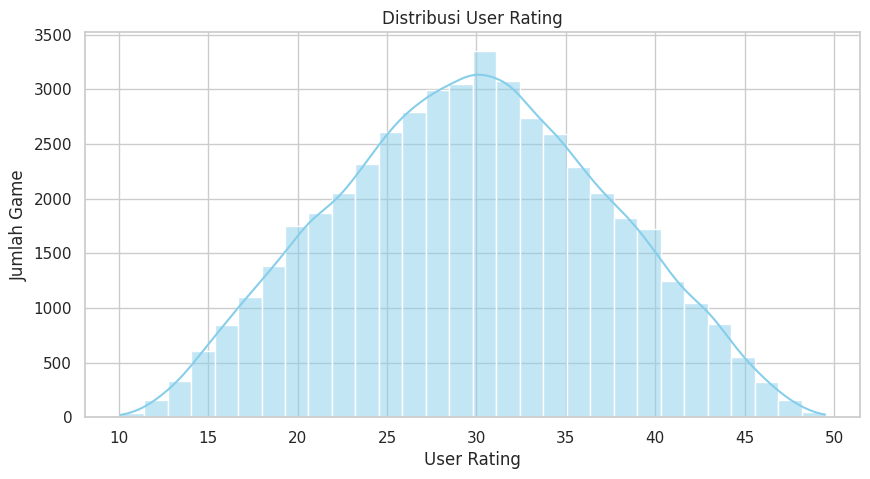

In [11]:
# Set style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Distribusi Rating
sns.histplot(df['User Rating'], bins=30, kde=True, color='skyblue')
plt.title('Distribusi User Rating')
plt.xlabel('User Rating')
plt.ylabel('Jumlah Game')
plt.show()

**Insight**:
- Bentuk distribusi terlihat mendekati normal (bell-shaped)
- Terdapat lebih dari 3000 game yang memiliki rating sekitar 30
- Karena rentang ratingnya dari 10-50 maka dibutuhkan penyekalaan ulang menjadi 1-5

# **Data Preparation**

## **Penyekalaan Variabel Rating**

In [12]:
def ubah_skala(data, kolom, skala_lama=(10, 50), skala_baru=(1, 5)):
    min_lama, max_lama = skala_lama
    min_baru, max_baru = skala_baru
    return min_baru + ((data[kolom] - min_lama) / (max_lama - min_lama)) * (max_baru - min_baru)

In [13]:
df['User Rating'] = ubah_skala(df, 'User Rating', skala_lama=(10, 50), skala_baru=(1, 5))

## **Content-Based Filtering**

In [14]:
# Mulai dari data sebelum disatukan genre-nya
cbf = df.copy()

# Hapus duplikat berdasarkan 'Game Title'
cbf = cbf.drop_duplicates(subset='Game Title').reset_index(drop=True)

In [15]:
# Konversi kolom penting ke list
titles = cbf['Game Title'].tolist()
genres = cbf['Genre'].tolist()

In [16]:
# Buat DataFrame
cbf_df = pd.DataFrame({
    'id': range(len(titles)),        # id numerik unik
    'game_name': titles,             # nama game
    'genre': genres,                 # genre
})

In [17]:
cbf_df

,id,game_name,genre
0,0,Grand Theft Auto V,Adventure
1,1,The Sims 4,Shooter
2,2,Minecraft,Adventure
3,3,Bioshock Infinite,Sports
4,4,Half-Life: Alyx,RPG
5,5,Sid Meier’s Civilization VI,Simulation
6,6,Just Dance 2024,Strategy
7,7,1000-Piece Puzzle,Sports
8,8,Spelunky 2,Adventure
9,9,Street Fighter V,Fighting


### **TF-IDF**

In [18]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()

# Melakukan perhitungan idf
tf.fit(cbf_df['genre'])

# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['adventure', 'fighting', 'party', 'puzzle', 'rpg', 'shooter',
       'simulation', 'sports', 'strategy'], dtype=object)

In [19]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(cbf_df['genre'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(40, 9)

In [20]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1

In [21]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre game
# Baris diisi dengan nama game

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=cbf_df.game_name
).sample(9, axis=1).sample(10, axis=0)

,adventure,shooter,puzzle,strategy,rpg,simulation,sports,party,fighting
game_name,,,,,,,,,
Super Mario Odyssey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Tetris,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Pokémon Scarlet & Violet,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Call of Duty: Modern Warfare 2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Fortnite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Mario Kart 8 Deluxe,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Super Smash Bros. Ultimate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Rocket League,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Spelunky 2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Collaborative Filtering**

In [22]:
# Reset index agar index jadi kolom
df_reset = df.reset_index()

# Ambil hanya kolom yang dibutuhkan
cf_df = df_reset[['index', 'Game Title', 'User Rating', 'Genre']].copy()

# Rename agar sesuai dengan konvensi: user, item, rating
cf_df.columns = ['userID', 'Game Title', 'User Rating', 'Genre']

# Buat Reader dengan range rating sesuai data
reader = Reader(rating_scale=(cf_df['User Rating'].min(), cf_df['User Rating'].max()))

# Buat dataset Surprise
data = Dataset.load_from_df(cf_df[['userID', 'Game Title', 'User Rating']], reader)

# Split data train-test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# **Model Development**

## **Content-Based Filtering**

### **Cosine Similarity**

In [23]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=cbf_df['game_name'], columns=cbf_df['game_name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (40, 40)


game_name,Counter-Strike: Global Offensive,Spelunky 2,The Legend of Zelda: Breath of the Wild,Half-Life: Alyx,Minecraft
game_name,,,,,
Super Mario Odyssey,0.0,0.0,0.0,0.0,0.0
1000-Piece Puzzle,0.0,0.0,0.0,0.0,0.0
League of Legends,0.0,0.0,0.0,0.0,0.0
The Legend of Zelda: Breath of the Wild,0.0,1.0,1.0,0.0,1.0
Super Smash Bros. Ultimate,0.0,0.0,0.0,0.0,0.0
Street Fighter V,0.0,0.0,0.0,0.0,0.0
FIFA 24,0.0,0.0,0.0,0.0,0.0
Call of Duty: Modern Warfare 2,0.0,0.0,0.0,0.0,0.0
Tetris,0.0,0.0,0.0,0.0,0.0


In [25]:
def game_recommendations(nama_game, similarity_data=cosine_sim_df, items=cbf_df[['game_name', 'genre']], k=5):

    # Pastikan nama_game ada di index similarity_data
    if nama_game not in similarity_data.index:
        raise ValueError(f"Game '{nama_game}' tidak ditemukan dalam data similarity.")

    # Cari posisi index game
    idx = similarity_data.columns.get_loc(nama_game)

    # Ambil index dari k game dengan similarity tertinggi (termasuk dirinya sendiri)
    index = similarity_data.iloc[:, idx].to_numpy().argpartition(range(-1, -k-1, -1))

    # Ambil nama game yang paling mirip berdasarkan index (urut dari paling mirip)
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Buang nama_game agar tidak rekomendasi ke diri sendiri
    closest = closest.drop(nama_game, errors='ignore')

    # Gabungkan dengan info game untuk tampilkan genre dll
    return pd.DataFrame(closest, columns=['game_name']).merge(items, on='game_name').head(k)

In [26]:
cbf_df[cbf_df.game_name.eq('Minecraft')]

,id,game_name,genre
2,2,Minecraft,Adventure


In [27]:
# Mendapatkan rekomendasi game yang mirip dengan Minecraft
game_recommendations('Minecraft')

,game_name,genre
0,Animal Crossing: New Horizons,Adventure
1,Spelunky 2,Adventure
2,The Legend of Zelda: Breath of the Wild,Adventure
3,Grand Theft Auto V,Adventure
4,Cuphead,Shooter


In [28]:
cbf_df[cbf_df.game_name.eq('Tekken 7')]

,id,game_name,genre
17,17,Tekken 7,Simulation


In [29]:
# Mendapatkan rekomendasi game yang mirip dengan Tekken 7
game_recommendations('Tekken 7')

,game_name,genre
0,Sid Meier’s Civilization VI,Simulation
1,Red Dead Redemption 2,Simulation
2,Mario Kart 8 Deluxe,Simulation
3,Counter-Strike: Global Offensive,Simulation
4,The Elder Scrolls V: Skyrim,Simulation


### **Evaluasi**

In [30]:
def precision_recall_content_based(input_game, recommended_games, tfidf=tf, k=5):
    """
    Menghitung precision dan recall berbasis cosine similarity antar TF-IDF genre dari game input dan hasil rekomendasi.

    Parameters:
    - input_game: str, judul game sebagai input
    - recommended_games: list of str, hasil rekomendasi judul game
    - tfidf: TF-IDF vectorizer yang sudah dilatih
    - k: jumlah rekomendasi yang dinilai

    Returns:
    - precision dan recall dalam persentase
    """
    input_tfidf = tf.transform([cbf_df[cbf_df['game_name'] == input_game]['genre'].values[0]])
    rec_tfidf = tf.transform(cbf_df[cbf_df['game_name'].isin(recommended_games)]['genre'])

    sim_scores = cosine_similarity(input_tfidf, rec_tfidf)[0]

    precision = sum(sim_scores[:k]) / k
    recall = sum(sim_scores[:k]) / sum(sim_scores) if sum(sim_scores) > 0 else 0

    return precision * 100, recall * 100

# Pilih beberapa game sebagai contoh evaluasi
input_games = ["Minecraft", "Tekken 7"]

# Evaluasi precision dan recall untuk masing-masing input
for game in input_games:
    recommended_titles = list(game_recommendations(game, k=5)['game_name'])
    precision, recall = precision_recall_content_based(game, recommended_titles, k=5)

    print(f"\nEvaluasi untuk '{game}':")
    print(f"Precision@5: {precision:.2f}%")
    print(f"Recall@5: {recall:.2f}%")



Evaluasi untuk 'Minecraft':
Precision@5: 80.00%
Recall@5: 100.00%

Evaluasi untuk 'Tekken 7':
Precision@5: 100.00%
Recall@5: 100.00%


## **Collaborative Filtering**

In [31]:
# Inisialisasi dan train model SVD
model = SVD()
model.fit(trainset)

In [32]:
def get_game_recommendations(user_id, df, model, top_n=10):
    user_rated_games = df[df['userID'] == user_id]['Game Title'].unique()
    all_games = df['Game Title'].unique()
    unrated_games = np.setdiff1d(all_games, user_rated_games)

    predictions = [model.predict(user_id, game) for game in unrated_games]
    predictions.sort(key=lambda x: x.est, reverse=True)

    recommended_game_titles = [pred.iid for pred in predictions[:top_n]]
    recommendations = df[df['Game Title'].isin(recommended_game_titles)][['Game Title', 'Genre']].drop_duplicates(subset=['Game Title'])
    return recommendations.reset_index(drop=True)

In [33]:
# Contoh rekomendasi untuk user 331
rekomendasi_user_331 = get_game_recommendations(user_id=331, df=cf_df, model=model)
print(rekomendasi_user_331)

                                Game Title       Genre
0                        1000-Piece Puzzle      Sports
1                                Fall Guys    Strategy
2           Call of Duty: Modern Warfare 2    Strategy
3  The Legend of Zelda: Breath of the Wild   Adventure
4                                 Tekken 7  Simulation
5            Animal Crossing: New Horizons   Adventure
6                       Kingdom Hearts III     Shooter
7                                 Portal 2    Strategy
8                                   Tetris     Shooter
9         Counter-Strike: Global Offensive  Simulation


In [34]:
# Contoh rekomendasi untuk user 20
rekomendasi_user_20 = get_game_recommendations(user_id=20, df=cf_df, model=model)
print(rekomendasi_user_20)

                                Game Title      Genre
0                        1000-Piece Puzzle     Sports
1                         Street Fighter V   Fighting
2           Call of Duty: Modern Warfare 2   Strategy
3  The Legend of Zelda: Breath of the Wild  Adventure
4            Animal Crossing: New Horizons  Adventure
5                                    Hades     Sports
6                                 Fortnite      Party
7                        League of Legends      Party
8                        Ghost of Tsushima        RPG
9                                 Portal 2   Strategy


### **Evaluasi**

In [35]:
# Evaluasi model
predictions = model.test(testset)
print("Root Mean Squared Error (RMSE):", accuracy.rmse(predictions))
print("Mean Absolute Error (MAE):", accuracy.mae(predictions))

RMSE: 0.7554
Root Mean Squared Error (RMSE): 0.7553646788735782
MAE:  0.6192
Mean Absolute Error (MAE): 0.6192209768763541
